In [159]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import librosa
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import pandas
import seaborn as sns
import csv
from sklearn import svm
import itertools
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pandas as pd
from scipy.special import comb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from scipy.stats import rankdata
from sklearn.ensemble import RandomForestClassifier as RFC
from matplotlib import style
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
DATADIR = "DATASET1"
CATEGORIES = ["Segmented_Laugh", "Segmented_NonLaugh1"]

# Defining Functions

In [5]:
def createcombinations(n):
    elements = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    a = list(itertools.combinations(elements, n))
    a = np.asarray(a).astype(int)
    return a

In [189]:
def create_training_data(t_frame, t_shift, n_mfccs, component, training_data, n_features):
    count=0
    error_count = 0
    laugh_counter = 0
    nonlaugh_counter = 0
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for aud in os.listdir(path):
            if aud == '.DS_Store':
                continue
            
            aud_array , sr = librosa.load(os.path.join(path,aud), sr=None)
            count+=1

            mfccs = []
            
            try:
                mfcc = (librosa.feature.mfcc(aud_array, sr=sr,  n_mfcc=20,  win_length = int(sr*t_frame), hop_length = int(sr*t_shift))) 
                
                mfcc_temp = mfcc[component,:]
                mean_mfccs = np.mean(np.asarray(mfcc_temp),axis = 1)
                std_mfccs = np.std(np.asarray(mfcc_temp), axis = 1)
                #var_mfccs = np.var(np.asarray(mfcc_temp), axis = 1)
                
                mfcc_delta = librosa.feature.delta(mfcc_temp)
                #mfcc_delta_mean = np.mean(np.asarray(mfcc_delta),axis = 1)
                #mfcc_delta_var = np.var(np.asarray(mfcc_delta),axis = 1)
                mfcc_delta_std = np.std(np.asarray(mfcc_delta),axis = 1)
                
                mfcc_delta2 = librosa.feature.delta(mfcc_delta)
                #mfcc_delta2_mean = np.mean(np.asarray(mfcc_delta2),axis = 1)
                #mfcc_delta2_var = np.var(np.asarray(mfcc_delta2),axis = 1)
                mfcc_delta2_std = np.std(np.asarray(mfcc_delta2),axis = 1)
                
                
                mfccs.append(mean_mfccs)
                mfccs.append(std_mfccs)
                #mfccs.append(var_mfccs)
                #mfccs.append(mfcc_delta_mean)
                #mfccs.append(mfcc_delta_var)
                mfccs.append(mfcc_delta_std)
                mfccs.append(mfcc_delta2_std)
                
                mfccs = np.asarray(mfccs).reshape(n_mfccs*n_features,1)
                
                training_data.append([mfccs.reshape(-1,1), class_num])
                if category == 'Segmented_Laugh':
                    laugh_counter +=1
                else:
                    nonlaugh_counter += 1
                    if nonlaugh_counter >= laugh_counter:
                        break

            except ValueError:
                pass
            
    return laugh_counter, nonlaugh_counter
    

# Main Loop

In [190]:
def scaling(X,n_mfcc):
    for i in range(n_mfcc):
        X[:,i] = X[:,i]/(np.mean(X[:,i]))
        

    #X[:,1] = np.square(X[:,1])
        
    return X

In [191]:
n_features = 4
t_frame = 0.025
t_shift = 0.01
n_mfcc = 20
component = createcombinations(n_mfcc)

for components in component:
    training_data = []
    laugh, nonlaugh = create_training_data(t_frame, t_shift, n_mfcc, components, training_data, n_features)
    print(laugh, nonlaugh)
    
random.shuffle(training_data) 
X = []
Y = []
for features, label in training_data:
    X.append(features)
    Y.append(label)
        
X = np.array(X).reshape(-1,n_mfcc*n_features)
Y = np.array(Y)
X = scaling(X,n_mfcc)

779 779


In [192]:
X.shape

(1558, 80)

In [186]:
 ##Using SFS ( is forward = True ) and SBS ( if forward = False)

In [193]:
 classifier = RFC(n_estimators=40)
sfs1 = SFS(classifier, 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',#scoring='accuracy',
           n_jobs = -1
           )

sfs1 = sfs1.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.9s finished

[2020-01-03 23:17:07] Features: 1/20 -- score: 0.7049501096682519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   18.8s finished

[2020-01-03 23:17:26] Features: 2/20 -- score: 0.7896236855031981[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   21.9s finished

[2020-01-03 23:17:48] Features: 3/20 -- score: 0.8332038539872926[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  77 out o

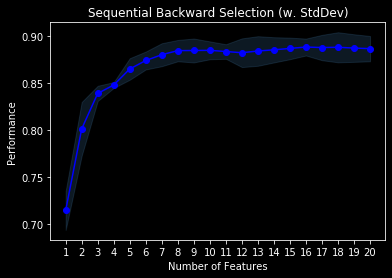

In [188]:
#RF Mean and std, Delta std

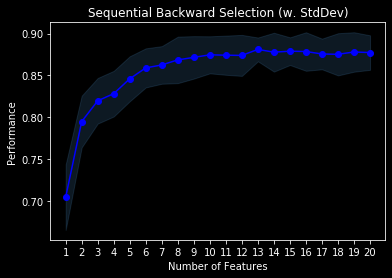

In [178]:
#RF Mean and std

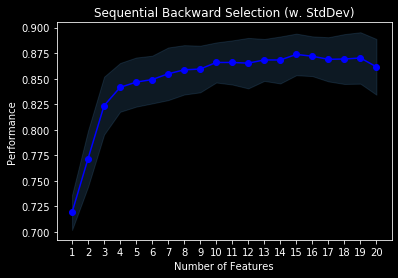

In [171]:
#RF Mean only

In [194]:
df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [195]:
df

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.70495,0.0510312,"[0.6875205456936226, 0.7361316568047338, 0.734...","(2,)","(2,)",0.039704,0.019852
2,0.789624,0.0384666,"[0.7670118343195266, 0.8369699211045366, 0.800...","(2, 40)","(2, 40)",0.0299283,0.0149641
3,0.833204,0.0294541,"[0.85387902695595, 0.855009040105194, 0.846010...","(1, 2, 40)","(1, 2, 40)",0.0229163,0.0114581
4,0.842769,0.0245532,"[0.8706648586456278, 0.8514135437212361, 0.847...","(0, 1, 2, 40)","(0, 1, 2, 40)",0.0191032,0.0095516
5,0.855003,0.0244312,"[0.8789858645627876, 0.8595290927021696, 0.866...","(0, 1, 2, 40, 41)","(0, 1, 2, 40, 41)",0.0190083,0.00950416
6,0.86845,0.0249546,"[0.8920529257067719, 0.8795200525969756, 0.871...","(0, 1, 2, 20, 40, 41)","(0, 1, 2, 20, 40, 41)",0.0194155,0.00970777
7,0.877922,0.025066,"[0.9077703813280736, 0.8793556870479947, 0.885...","(0, 1, 2, 20, 40, 41, 45)","(0, 1, 2, 20, 40, 41, 45)",0.0195022,0.0097511
8,0.877403,0.0236261,"[0.8971688034188035, 0.8898134451019067, 0.889...","(0, 1, 2, 20, 40, 41, 45, 51)","(0, 1, 2, 20, 40, 41, 45, 51)",0.0183819,0.00919095
9,0.878467,0.0245538,"[0.8975591715976331, 0.8915803747534516, 0.890...","(0, 1, 2, 6, 20, 40, 41, 45, 51)","(0, 1, 2, 6, 20, 40, 41, 45, 51)",0.0191037,0.00955184
10,0.881184,0.0222448,"[0.9038461538461537, 0.8881492439184747, 0.891...","(0, 1, 2, 6, 13, 20, 40, 41, 45, 51)","(0, 1, 2, 6, 13, 20, 40, 41, 45, 51)",0.0173072,0.00865361


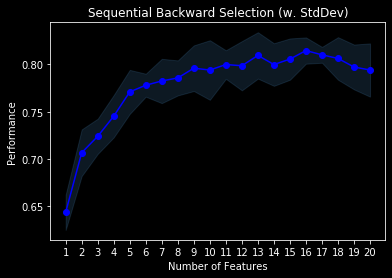

In [154]:
style.use('dark_background')
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
#plt.grid()
plt.show()



In [135]:
df#RF Mean+std, Delta std, Delta2 std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.619388,0.0345274,"[0.5705128205128205, 0.6506410256410257, 0.634...","(2,)","(2,)",0.0268635,0.0134318
2,0.725273,0.0302367,"[0.6858974358974359, 0.7371794871794872, 0.753...","(2, 21)","(2, 21)",0.0235252,0.0117626
3,0.758011,0.0210071,"[0.7307692307692307, 0.7692307692307693, 0.775...","(2, 21, 40)","(2, 21, 40)",0.0163442,0.00817211
4,0.770868,0.0121119,"[0.7596153846153846, 0.782051282051282, 0.7756...","(1, 2, 21, 40)","(1, 2, 21, 40)",0.00942349,0.00471174
5,0.782407,0.0263151,"[0.7596153846153846, 0.8205128205128205, 0.772...","(1, 2, 21, 40, 54)","(1, 2, 21, 40, 54)",0.0204741,0.010237
6,0.796526,0.0349884,"[0.7756410256410257, 0.8461538461538461, 0.801...","(1, 2, 21, 40, 54, 69)","(1, 2, 21, 40, 54, 69)",0.0272222,0.0136111
7,0.795881,0.0287417,"[0.7596153846153846, 0.8269230769230769, 0.807...","(1, 2, 21, 40, 45, 54, 69)","(1, 2, 21, 40, 45, 54, 69)",0.022362,0.011181
8,0.797159,0.0327617,"[0.7788461538461539, 0.8461538461538461, 0.798...","(1, 2, 9, 21, 40, 45, 54, 69)","(1, 2, 9, 21, 40, 45, 54, 69)",0.0254897,0.0127449
9,0.801059,0.0297362,"[0.7660256410256411, 0.8205128205128205, 0.810...","(1, 2, 9, 21, 40, 42, 45, 54, 69)","(1, 2, 9, 21, 40, 42, 45, 54, 69)",0.0231357,0.0115679
10,0.801671,0.0186332,"[0.7756410256410257, 0.8205128205128205, 0.804...","(1, 2, 9, 16, 21, 40, 42, 45, 54, 69)","(1, 2, 9, 16, 21, 40, 42, 45, 54, 69)",0.0144973,0.00724863


In [127]:
df#RF Mean+std, Delta Mean+std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.631596,0.027842,"[0.6185897435897436, 0.5961538461538461, 0.657...","(60,)","(60,)",0.021662,0.010831
2,0.722076,0.0154029,"[0.7307692307692307, 0.7211538461538461, 0.701...","(2, 60)","(2, 60)",0.011984,0.00599201
3,0.749036,0.0323744,"[0.7564102564102564, 0.7307692307692307, 0.791...","(2, 16, 60)","(2, 16, 60)",0.0251884,0.0125942
4,0.770852,0.0175633,"[0.7788461538461539, 0.7467948717948718, 0.782...","(2, 12, 16, 60)","(2, 12, 16, 60)",0.0136649,0.00683243
5,0.778544,0.0211621,"[0.7916666666666666, 0.7532051282051282, 0.791...","(2, 12, 16, 17, 60)","(2, 12, 16, 17, 60)",0.0164648,0.00823241
6,0.785604,0.0171657,"[0.8076923076923077, 0.7724358974358975, 0.788...","(1, 2, 12, 16, 17, 60)","(1, 2, 12, 16, 17, 60)",0.0133555,0.00667774
7,0.798466,0.0198,"[0.7916666666666666, 0.7724358974358975, 0.817...","(1, 2, 12, 16, 17, 43, 60)","(1, 2, 12, 16, 17, 43, 60)",0.0154051,0.00770255
8,0.797808,0.0149463,"[0.7948717948717948, 0.7884615384615384, 0.820...","(1, 2, 7, 12, 16, 17, 43, 60)","(1, 2, 7, 12, 16, 17, 43, 60)",0.0116288,0.00581438
9,0.807423,0.0169186,"[0.8108974358974359, 0.8012820512820513, 0.804...","(1, 2, 7, 12, 16, 17, 43, 55, 60)","(1, 2, 7, 12, 16, 17, 43, 55, 60)",0.0131632,0.00658161
10,0.800368,0.0189839,"[0.7980769230769231, 0.782051282051282, 0.8173...","(1, 2, 7, 12, 16, 17, 43, 55, 60, 72)","(1, 2, 7, 12, 16, 17, 43, 55, 60, 72)",0.0147701,0.00738506


In [119]:
df#RF Mean+std, Delta std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.629677,0.0215317,"[0.6474358974358975, 0.6121794871794872, 0.608...","(2,)","(2,)",0.0167524,0.00837619
2,0.732994,0.019124,"[0.7275641025641025, 0.7532051282051282, 0.708...","(2, 21)","(2, 21)",0.0148791,0.00743957
3,0.761861,0.0240051,"[0.7724358974358975, 0.7916666666666666, 0.737...","(0, 2, 21)","(0, 2, 21)",0.0186768,0.00933841
4,0.767026,0.0288554,"[0.7980769230769231, 0.7660256410256411, 0.730...","(0, 1, 2, 21)","(0, 1, 2, 21)",0.0224504,0.0112252
5,0.785604,0.0345065,"[0.8269230769230769, 0.8076923076923077, 0.762...","(0, 1, 2, 21, 40)","(0, 1, 2, 21, 40)",0.0268473,0.0134236
6,0.801654,0.0291075,"[0.842948717948718, 0.8044871794871795, 0.7948...","(0, 1, 2, 17, 21, 40)","(0, 1, 2, 17, 21, 40)",0.0226467,0.0113233
7,0.808697,0.0298059,"[0.8365384615384616, 0.8365384615384616, 0.788...","(0, 1, 2, 17, 21, 29, 40)","(0, 1, 2, 17, 21, 29, 40)",0.02319,0.011595
8,0.813834,0.0189687,"[0.8365384615384616, 0.8141025641025641, 0.817...","(0, 1, 2, 12, 17, 21, 29, 40)","(0, 1, 2, 12, 17, 21, 29, 40)",0.0147583,0.00737916
9,0.815132,0.0325416,"[0.8493589743589743, 0.8397435897435898, 0.801...","(0, 1, 2, 12, 17, 20, 21, 29, 40)","(0, 1, 2, 12, 17, 20, 21, 29, 40)",0.0253185,0.0126592
10,0.816414,0.0228561,"[0.8461538461538461, 0.8269230769230769, 0.798...","(0, 1, 2, 12, 17, 20, 21, 29, 39, 40)","(0, 1, 2, 12, 17, 20, 21, 29, 39, 40)",0.0177828,0.00889141


In [111]:
df#RF Mean+std, Delta Mean

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.638677,0.0426841,"[0.6826923076923077, 0.6217948717948718, 0.589...","(2,)","(2,)",0.0332097,0.0166048
2,0.719508,0.0252698,"[0.7564102564102564, 0.6987179487179487, 0.708...","(2, 21)","(2, 21)",0.0196607,0.00983037
3,0.747767,0.0344616,"[0.7852564102564102, 0.7051282051282052, 0.733...","(0, 2, 21)","(0, 2, 21)",0.0268123,0.0134062
4,0.762572,0.0339345,"[0.7660256410256411, 0.7532051282051282, 0.724...","(0, 1, 2, 21)","(0, 1, 2, 21)",0.0264022,0.0132011
5,0.785,0.0156464,"[0.7884615384615384, 0.7948717948717948, 0.772...","(0, 1, 2, 21, 51)","(0, 1, 2, 21, 51)",0.0121734,0.00608671
6,0.790765,0.0259983,"[0.8108974358974359, 0.8108974358974359, 0.759...","(0, 1, 2, 7, 21, 51)","(0, 1, 2, 7, 21, 51)",0.0202276,0.0101138
7,0.790132,0.0324299,"[0.7980769230769231, 0.8237179487179487, 0.75,...","(0, 1, 2, 7, 19, 21, 51)","(0, 1, 2, 7, 19, 21, 51)",0.0252315,0.0126158
8,0.790132,0.0266887,"[0.7916666666666666, 0.8205128205128205, 0.762...","(0, 1, 2, 7, 19, 21, 44, 51)","(0, 1, 2, 7, 19, 21, 44, 51)",0.0207647,0.0103824
9,0.797196,0.0246498,"[0.7852564102564102, 0.8269230769230769, 0.782...","(0, 1, 2, 7, 19, 21, 23, 44, 51)","(0, 1, 2, 7, 19, 21, 23, 44, 51)",0.0191784,0.00958918
10,0.793987,0.029532,"[0.7948717948717948, 0.8012820512820513, 0.75,...","(0, 1, 2, 7, 19, 21, 23, 44, 47, 51)","(0, 1, 2, 7, 19, 21, 23, 44, 47, 51)",0.0229769,0.0114884


In [103]:
df#RF Delta Mean and std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.629562,0.0541528,"[0.6474358974358975, 0.6474358974358975, 0.612...","(20,)","(20,)",0.0421327,0.0210664
2,0.683586,0.0292408,"[0.6891025641025641, 0.6442307692307693, 0.676...","(20, 21)","(20, 21)",0.0227503,0.0113752
3,0.711865,0.0387962,"[0.7307692307692307, 0.6762820512820513, 0.679...","(20, 21, 39)","(20, 21, 39)",0.0301847,0.0150924
4,0.715695,0.0203936,"[0.7243589743589743, 0.6987179487179487, 0.701...","(2, 20, 21, 39)","(2, 20, 21, 39)",0.0158669,0.00793344
5,0.734322,0.0324454,"[0.7403846153846154, 0.6987179487179487, 0.714...","(0, 2, 20, 21, 39)","(0, 2, 20, 21, 39)",0.0252436,0.0126218
6,0.745227,0.0308331,"[0.7692307692307693, 0.7147435897435898, 0.733...","(0, 2, 9, 20, 21, 39)","(0, 2, 9, 20, 21, 39)",0.0239892,0.0119946
7,0.744574,0.0193497,"[0.7564102564102564, 0.7339743589743589, 0.727...","(0, 1, 2, 9, 20, 21, 39)","(0, 1, 2, 9, 20, 21, 39)",0.0150547,0.00752734
8,0.748433,0.0283613,"[0.7692307692307693, 0.717948717948718, 0.7339...","(0, 1, 2, 9, 20, 21, 25, 39)","(0, 1, 2, 9, 20, 21, 25, 39)",0.0220661,0.011033
9,0.745223,0.0204216,"[0.75, 0.7339743589743589, 0.7371794871794872,...","(0, 1, 2, 9, 20, 21, 25, 38, 39)","(0, 1, 2, 9, 20, 21, 25, 38, 39)",0.0158887,0.00794435
10,0.753565,0.0260041,"[0.7692307692307693, 0.7275641025641025, 0.733...","(0, 1, 2, 9, 20, 21, 25, 33, 38, 39)","(0, 1, 2, 9, 20, 21, 25, 33, 38, 39)",0.0202321,0.010116


In [92]:
df#RF Delta var

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.628962,0.0374137,"[0.6474358974358975, 0.6025641025641025, 0.634...","(0,)","(0,)",0.0291091,0.0145546
2,0.68227,0.023325,"[0.6794871794871795, 0.6698717948717948, 0.673...","(0, 1)","(0, 1)",0.0181476,0.00907382
3,0.714313,0.0424326,"[0.7339743589743589, 0.7275641025641025, 0.689...","(0, 1, 14)","(0, 1, 14)",0.033014,0.016507
4,0.722043,0.0274372,"[0.7371794871794872, 0.7371794871794872, 0.698...","(0, 1, 6, 14)","(0, 1, 6, 14)",0.0213471,0.0106735
5,0.723983,0.031811,"[0.7532051282051282, 0.7211538461538461, 0.689...","(0, 1, 6, 9, 14)","(0, 1, 6, 9, 14)",0.02475,0.012375
6,0.734897,0.0231861,"[0.7371794871794872, 0.7371794871794872, 0.714...","(0, 1, 5, 6, 9, 14)","(0, 1, 5, 6, 9, 14)",0.0180396,0.00901979
7,0.734268,0.0306253,"[0.7435897435897436, 0.7339743589743589, 0.695...","(0, 1, 5, 6, 9, 12, 14)","(0, 1, 5, 6, 9, 12, 14)",0.0238275,0.0119138
8,0.734892,0.0289886,"[0.7435897435897436, 0.7339743589743589, 0.708...","(0, 1, 5, 6, 8, 9, 12, 14)","(0, 1, 5, 6, 8, 9, 12, 14)",0.0225542,0.0112771
9,0.736212,0.0331485,"[0.7692307692307693, 0.7147435897435898, 0.698...","(0, 1, 5, 6, 8, 9, 10, 12, 14)","(0, 1, 5, 6, 8, 9, 10, 12, 14)",0.0257907,0.0128953
10,0.737469,0.0186565,"[0.7403846153846154, 0.7435897435897436, 0.717...","(0, 1, 5, 6, 8, 9, 10, 12, 14, 17)","(0, 1, 5, 6, 8, 9, 10, 12, 14, 17)",0.0145154,0.0072577


In [77]:
df#RF Delta std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.618739,0.0396665,"[0.5961538461538461, 0.6634615384615384, 0.576...","(0,)","(0,)",0.0308619,0.0154309
2,0.688739,0.0322292,"[0.6538461538461539, 0.6666666666666666, 0.714...","(0, 1)","(0, 1)",0.0250754,0.0125377
3,0.714384,0.0178625,"[0.7243589743589743, 0.7051282051282052, 0.730...","(0, 1, 14)","(0, 1, 14)",0.0138976,0.00694881
4,0.715012,0.00833392,"[0.7051282051282052, 0.717948717948718, 0.7211...","(0, 1, 9, 14)","(0, 1, 9, 14)",0.00648407,0.00324204
5,0.724069,0.0353277,"[0.7147435897435898, 0.7115384615384616, 0.727...","(0, 1, 9, 11, 14)","(0, 1, 9, 11, 14)",0.0274862,0.0137431
6,0.719529,0.0173526,"[0.7307692307692307, 0.7147435897435898, 0.724...","(0, 1, 9, 11, 14, 18)","(0, 1, 9, 11, 14, 18)",0.0135009,0.00675047
7,0.733693,0.0398974,"[0.7339743589743589, 0.7019230769230769, 0.753...","(0, 1, 6, 9, 11, 14, 18)","(0, 1, 6, 9, 11, 14, 18)",0.0310416,0.0155208
8,0.734297,0.0294328,"[0.7564102564102564, 0.6955128205128205, 0.746...","(0, 1, 6, 9, 11, 12, 14, 18)","(0, 1, 6, 9, 11, 12, 14, 18)",0.0228997,0.0114499
9,0.736865,0.0244624,"[0.7564102564102564, 0.7083333333333334, 0.743...","(0, 1, 6, 9, 11, 12, 14, 18, 19)","(0, 1, 6, 9, 11, 12, 14, 18, 19)",0.0190326,0.00951628
10,0.729806,0.015277,"[0.7275641025641025, 0.7147435897435898, 0.737...","(0, 1, 6, 9, 11, 12, 13, 14, 18, 19)","(0, 1, 6, 9, 11, 12, 13, 14, 18, 19)",0.011886,0.00594301


In [85]:
df#RF Delta Mean

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.537911,0.0346487,"[0.5352564102564102, 0.5384615384615384, 0.554...","(1,)","(1,)",0.0269578,0.0134789
2,0.574429,0.0366359,"[0.5961538461538461, 0.5865384615384616, 0.605...","(1, 2)","(1, 2)",0.028504,0.014252
3,0.592444,0.0223082,"[0.5865384615384616, 0.6025641025641025, 0.605...","(0, 1, 2)","(0, 1, 2)",0.0173566,0.00867828
4,0.609111,0.0189328,"[0.5897435897435898, 0.6346153846153846, 0.602...","(0, 1, 2, 7)","(0, 1, 2, 7)",0.0147304,0.00736519
5,0.621948,0.0178207,"[0.6410256410256411, 0.6346153846153846, 0.605...","(0, 1, 2, 5, 7)","(0, 1, 2, 5, 7)",0.0138651,0.00693257
6,0.632862,0.0148582,"[0.6378205128205128, 0.6506410256410257, 0.615...","(0, 1, 2, 5, 7, 13)","(0, 1, 2, 5, 7, 13)",0.0115602,0.0057801
7,0.621299,0.0162266,"[0.6314102564102564, 0.6378205128205128, 0.602...","(0, 1, 2, 5, 7, 8, 13)","(0, 1, 2, 5, 7, 8, 13)",0.0126248,0.00631241
8,0.624487,0.0183965,"[0.6346153846153846, 0.6410256410256411, 0.628...","(0, 1, 2, 3, 5, 7, 8, 13)","(0, 1, 2, 3, 5, 7, 8, 13)",0.0143131,0.00715656
9,0.622581,0.0185512,"[0.6442307692307693, 0.6314102564102564, 0.621...","(0, 1, 2, 3, 5, 7, 8, 13, 19)","(0, 1, 2, 3, 5, 7, 8, 13, 19)",0.0144334,0.00721672
10,0.620691,0.0186299,"[0.625, 0.5993589743589743, 0.6314102564102564...","(0, 1, 2, 3, 5, 7, 8, 9, 13, 19)","(0, 1, 2, 3, 5, 7, 8, 9, 13, 19)",0.0144947,0.00724734


In [66]:
df#RF mean, std, var

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.63993,0.0248596,"[0.6282051282051282, 0.6538461538461539, 0.663...","(2,)","(2,)",0.0193416,0.00967079
2,0.717552,0.0273393,"[0.7019230769230769, 0.7467948717948718, 0.737...","(2, 41)","(2, 41)",0.0212709,0.0106354
3,0.753524,0.0308393,"[0.7147435897435898, 0.782051282051282, 0.7756...","(2, 20, 41)","(2, 20, 41)",0.023994,0.011997
4,0.760587,0.0170624,"[0.75, 0.7788461538461539, 0.7724358974358975,...","(2, 20, 30, 41)","(2, 20, 30, 41)",0.0132751,0.00663757
5,0.772175,0.024965,"[0.7435897435897436, 0.7788461538461539, 0.785...","(0, 2, 20, 30, 41)","(0, 2, 20, 30, 41)",0.0194237,0.00971183
6,0.792043,0.0336833,"[0.7692307692307693, 0.8333333333333334, 0.804...","(0, 1, 2, 20, 30, 41)","(0, 1, 2, 20, 30, 41)",0.0262067,0.0131034
7,0.802308,0.0234232,"[0.7980769230769231, 0.8365384615384616, 0.794...","(0, 1, 2, 20, 30, 41, 51)","(0, 1, 2, 20, 30, 41, 51)",0.0182241,0.00911204
8,0.802953,0.0342198,"[0.7724358974358975, 0.8493589743589743, 0.807...","(0, 1, 2, 7, 20, 30, 41, 51)","(0, 1, 2, 7, 20, 30, 41, 51)",0.0266241,0.0133121
9,0.811919,0.0213984,"[0.7916666666666666, 0.8365384615384616, 0.823...","(0, 1, 2, 7, 20, 21, 30, 41, 51)","(0, 1, 2, 7, 20, 21, 30, 41, 51)",0.0166487,0.00832436
10,0.807428,0.0317732,"[0.7756410256410257, 0.8365384615384616, 0.836...","(0, 1, 2, 7, 20, 21, 22, 30, 41, 51)","(0, 1, 2, 7, 20, 21, 22, 30, 41, 51)",0.0247206,0.0123603


In [58]:
df#RF Mean nd Variance

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.627746,0.0201182,"[0.6282051282051282, 0.6153846153846154, 0.605...","(2,)","(2,)",0.0156526,0.00782632
2,0.720136,0.0191048,"[0.7275641025641025, 0.6987179487179487, 0.730...","(2, 21)","(2, 21)",0.0148642,0.00743209
3,0.749702,0.01386,"[0.7564102564102564, 0.7435897435897436, 0.740...","(0, 2, 21)","(0, 2, 21)",0.0107836,0.00539179
4,0.76574,0.0186608,"[0.7852564102564102, 0.7596153846153846, 0.762...","(0, 1, 2, 21)","(0, 1, 2, 21)",0.0145187,0.00725936
5,0.781158,0.0199494,"[0.7916666666666666, 0.7596153846153846, 0.769...","(0, 1, 2, 20, 21)","(0, 1, 2, 20, 21)",0.0155213,0.00776067
6,0.79591,0.0251131,"[0.8269230769230769, 0.7788461538461539, 0.775...","(0, 1, 2, 20, 21, 36)","(0, 1, 2, 20, 21, 36)",0.0195389,0.00976944
7,0.802308,0.0262907,"[0.8269230769230769, 0.7948717948717948, 0.769...","(0, 1, 2, 11, 20, 21, 36)","(0, 1, 2, 11, 20, 21, 36)",0.020455,0.0102275
8,0.801055,0.0319699,"[0.8333333333333334, 0.782051282051282, 0.7660...","(0, 1, 2, 11, 20, 21, 31, 36)","(0, 1, 2, 11, 20, 21, 31, 36)",0.0248737,0.0124368
9,0.806175,0.024497,"[0.8205128205128205, 0.7980769230769231, 0.772...","(0, 1, 2, 11, 20, 21, 31, 36, 38)","(0, 1, 2, 11, 20, 21, 31, 36, 38)",0.0190595,0.00952973
10,0.804256,0.0278482,"[0.8333333333333334, 0.7884615384615384, 0.772...","(0, 1, 2, 11, 14, 20, 21, 31, 36, 38)","(0, 1, 2, 11, 14, 20, 21, 31, 36, 38)",0.0216668,0.0108334


In [48]:
df#RF Mean and std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.631543,0.0218232,"[0.6410256410256411, 0.6506410256410257, 0.641...","(2,)","(2,)",0.0169792,0.0084896
2,0.71696,0.02168,"[0.7211538461538461, 0.6891025641025641, 0.708...","(2, 21)","(2, 21)",0.0168678,0.00843389
3,0.747122,0.0208634,"[0.7467948717948718, 0.7243589743589743, 0.737...","(2, 21, 39)","(2, 21, 39)",0.0162324,0.00811621
4,0.762527,0.0176149,"[0.7564102564102564, 0.75, 0.75, 0.78525641025...","(2, 10, 21, 39)","(2, 10, 21, 39)",0.013705,0.00685251
5,0.775368,0.0197341,"[0.7564102564102564, 0.7724358974358975, 0.762...","(2, 10, 21, 29, 39)","(2, 10, 21, 29, 39)",0.0153538,0.00767689
6,0.77794,0.0182976,"[0.7756410256410257, 0.7596153846153846, 0.766...","(1, 2, 10, 21, 29, 39)","(1, 2, 10, 21, 29, 39)",0.0142361,0.00711806
7,0.790786,0.0206407,"[0.7980769230769231, 0.7756410256410257, 0.769...","(1, 2, 5, 10, 21, 29, 39)","(1, 2, 5, 10, 21, 29, 39)",0.0160592,0.00802959
8,0.785637,0.0162544,"[0.7852564102564102, 0.7628205128205128, 0.785...","(1, 2, 5, 10, 21, 23, 29, 39)","(1, 2, 5, 10, 21, 23, 29, 39)",0.0126465,0.00632325
9,0.801683,0.0178683,"[0.8044871794871795, 0.8141025641025641, 0.801...","(0, 1, 2, 5, 10, 21, 23, 29, 39)","(0, 1, 2, 5, 10, 21, 23, 29, 39)",0.0139021,0.00695107
10,0.808102,0.0133053,"[0.7916666666666666, 0.8108974358974359, 0.817...","(0, 1, 2, 5, 10, 21, 23, 29, 30, 39)","(0, 1, 2, 5, 10, 21, 23, 29, 30, 39)",0.010352,0.00517599


In [18]:
df#RF mean only

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.633532,0.0236821,"[0.6410256410256411, 0.6057692307692307, 0.618...","(2,)","(2,)",0.0184255,0.00921274
2,0.695753,0.0211558,"[0.7147435897435898, 0.6730769230769231, 0.689...","(2, 10)","(2, 10)",0.0164599,0.00822997
3,0.7317,0.0289527,"[0.7596153846153846, 0.6923076923076923, 0.737...","(2, 10, 16)","(2, 10, 16)",0.0225262,0.0112631
4,0.745161,0.0264153,"[0.7628205128205128, 0.7371794871794872, 0.724...","(2, 7, 10, 16)","(2, 7, 10, 16)",0.020552,0.010276
5,0.757386,0.0168704,"[0.7596153846153846, 0.7435897435897436, 0.743...","(2, 7, 10, 16, 18)","(2, 7, 10, 16, 18)",0.0131257,0.00656287
6,0.770236,0.021593,"[0.7564102564102564, 0.75, 0.7660256410256411,...","(2, 7, 8, 10, 16, 18)","(2, 7, 8, 10, 16, 18)",0.0168001,0.00840003
7,0.772783,0.0131762,"[0.7852564102564102, 0.7564102564102564, 0.769...","(0, 2, 7, 8, 10, 16, 18)","(0, 2, 7, 8, 10, 16, 18)",0.0102515,0.00512575
8,0.781787,0.0155053,"[0.7852564102564102, 0.7660256410256411, 0.769...","(0, 1, 2, 7, 8, 10, 16, 18)","(0, 1, 2, 7, 8, 10, 16, 18)",0.0120637,0.00603183
9,0.792725,0.0364717,"[0.8108974358974359, 0.75, 0.7692307692307693,...","(0, 1, 2, 5, 7, 8, 10, 16, 18)","(0, 1, 2, 5, 7, 8, 10, 16, 18)",0.0283762,0.0141881
10,0.799119,0.0228527,"[0.8205128205128205, 0.7852564102564102, 0.772...","(0, 1, 2, 5, 7, 8, 10, 12, 16, 18)","(0, 1, 2, 5, 7, 8, 10, 12, 16, 18)",0.0177802,0.0088901


In [30]:
df#RF std only

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.619396,0.0173116,"[0.6378205128205128, 0.6057692307692307, 0.621...","(1,)","(1,)",0.013469,0.00673452
2,0.682312,0.0200102,"[0.6634615384615384, 0.6826923076923077, 0.695...","(1, 5)","(1, 5)",0.0155686,0.00778431
3,0.699702,0.0499569,"[0.6987179487179487, 0.6987179487179487, 0.647...","(1, 5, 15)","(1, 5, 15)",0.0388682,0.0194341
4,0.710571,0.0335477,"[0.6698717948717948, 0.6987179487179487, 0.708...","(1, 3, 5, 15)","(1, 3, 5, 15)",0.0261013,0.0130506
5,0.720186,0.0338026,"[0.6826923076923077, 0.7532051282051282, 0.717...","(0, 1, 3, 5, 15)","(0, 1, 3, 5, 15)",0.0262996,0.0131498
6,0.727899,0.0224633,"[0.7115384615384616, 0.7275641025641025, 0.721...","(0, 1, 3, 5, 9, 15)","(0, 1, 3, 5, 9, 15)",0.0174772,0.00873861
7,0.747155,0.0248184,"[0.7211538461538461, 0.7435897435897436, 0.740...","(0, 1, 3, 5, 9, 10, 15)","(0, 1, 3, 5, 9, 10, 15)",0.0193096,0.00965478
8,0.740066,0.0149923,"[0.7275641025641025, 0.7243589743589743, 0.75,...","(0, 1, 3, 5, 9, 10, 11, 15)","(0, 1, 3, 5, 9, 10, 11, 15)",0.0116645,0.00583224
9,0.745215,0.0179091,"[0.7275641025641025, 0.7403846153846154, 0.753...","(0, 1, 2, 3, 5, 9, 10, 11, 15)","(0, 1, 2, 3, 5, 9, 10, 11, 15)",0.0139339,0.00696693
10,0.742659,0.0284068,"[0.7083333333333334, 0.7564102564102564, 0.740...","(0, 1, 2, 3, 5, 9, 10, 11, 12, 15)","(0, 1, 2, 3, 5, 9, 10, 11, 12, 15)",0.0221015,0.0110507


In [38]:
df#RF var only

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.610426,0.0235028,"[0.6025641025641025, 0.6314102564102564, 0.599...","(1,)","(1,)",0.018286,0.00914298
2,0.681613,0.0239127,"[0.7083333333333334, 0.6923076923076923, 0.685...","(0, 1)","(0, 1)",0.0186049,0.00930246
3,0.708577,0.0412589,"[0.7275641025641025, 0.7628205128205128, 0.679...","(0, 1, 15)","(0, 1, 15)",0.0321009,0.0160504
4,0.716915,0.0419073,"[0.75, 0.7628205128205128, 0.6858974358974359,...","(0, 1, 5, 15)","(0, 1, 5, 15)",0.0326053,0.0163027
5,0.722734,0.023864,"[0.7403846153846154, 0.7403846153846154, 0.698...","(0, 1, 5, 14, 15)","(0, 1, 5, 14, 15)",0.018567,0.00928348
6,0.725273,0.0183648,"[0.7403846153846154, 0.7435897435897436, 0.708...","(0, 1, 3, 5, 14, 15)","(0, 1, 3, 5, 14, 15)",0.0142884,0.00714421
7,0.73426,0.0401351,"[0.7756410256410257, 0.7628205128205128, 0.721...","(0, 1, 3, 5, 8, 14, 15)","(0, 1, 3, 5, 8, 14, 15)",0.0312265,0.0156132
8,0.732978,0.0200256,"[0.75, 0.7532051282051282, 0.7147435897435898,...","(0, 1, 3, 5, 8, 11, 14, 15)","(0, 1, 3, 5, 8, 11, 14, 15)",0.0155806,0.00779029
9,0.740033,0.0159152,"[0.7339743589743589, 0.7628205128205128, 0.737...","(0, 1, 3, 5, 8, 11, 14, 15, 17)","(0, 1, 3, 5, 8, 11, 14, 15, 17)",0.0123826,0.00619128
10,0.740695,0.0300577,"[0.7403846153846154, 0.7788461538461539, 0.737...","(0, 1, 3, 5, 8, 11, 12, 14, 15, 17)","(0, 1, 3, 5, 8, 11, 12, 14, 15, 17)",0.0233859,0.0116929
